<a href="https://colab.research.google.com/github/SutapaSusovita/CodeAlpha_Handwritten-character-recognition/blob/main/handwriting_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset files:
['emnist-letters-mapping.txt', 'emnist-letters-test.csv', 'emnist-mnist-mapping.txt', 'emnist-digits-train.csv', 'emnist-bymerge-mapping.txt', 'emnist-balanced-train.csv', 'emnist-digits-test.csv', 'emnist-balanced-test.csv', 'emnist-mnist-test.csv', 'emnist-letters-train.csv', 'emnist-byclass-train.csv', 'emnist-bymerge-test.csv', 'emnist-balanced-mapping.txt', 'emnist-mnist-train.csv', 'emnist-digits-mapping.txt', 'emnist-bymerge-train.csv', 'emnist-byclass-test.csv', 'emnist_source_files', 'emnist-byclass-mapping.txt']
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3718/3720 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7915 - loss: 0.7233
Epoch 1: val_accuracy improved from -inf to 0.92782, saving model to best_model.keras
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 112s 30ms/step - accuracy: 0.7916 - loss: 0.7230 - val_accuracy: 0.9278 - val_loss: 0.2299 - learning_rate: 0.0010
Epoch 2/10
3718/3720 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9387 - loss: 0.1905
Epoch 2: val_accuracy improved from 0.92782 to 0.93999, saving model to best_model.keras
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 137s 28ms/step - accuracy: 0.9387 - loss: 0.1905 - val_accuracy: 0.9400 - val_loss: 0.1862 - learning_rate: 0.0010
Epoch 3/10
3719/3720 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9535 - loss: 0.1375
Epoch 3: val_accuracy improved from 0.93999 to 0.94284, saving model to best_model.keras
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 146s 29ms/step - accuracy: 0.9535 - loss: 0.1375 - val_accuracy: 0.9428 - val_loss: 0.1712 - learning_rate: 0.0010
Epoch 4/10
3718/3720 ━━━━━━━━━━

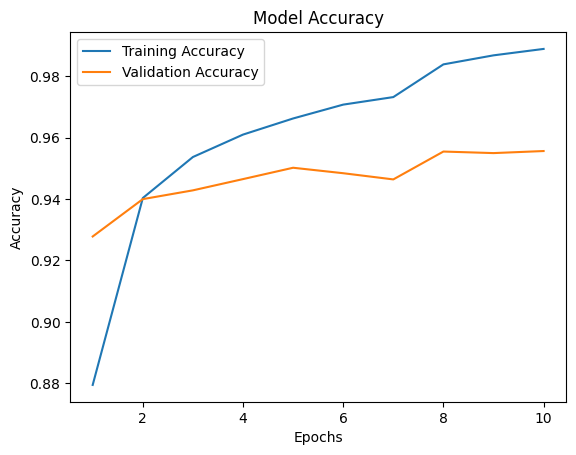

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import kagglehub
import string

# Login and download EMNIST dataset
kagglehub.login()
emnist_path = kagglehub.dataset_download('crawford/emnist')

print("Dataset files:")
print(os.listdir(emnist_path))

# Load EMNIST letters dataset
training_letter = pd.read_csv(os.path.join(emnist_path, 'emnist-letters-train.csv'))
testing_letter = pd.read_csv(os.path.join(emnist_path, 'emnist-letters-test.csv'))

x_emnist_train = training_letter.iloc[:, 1:].values / 255.0
y_emnist_train = training_letter.iloc[:, 0].values + 9  # Convert 1-26 to 10-35

x_emnist_test = testing_letter.iloc[:, 1:].values / 255.0
y_emnist_test = testing_letter.iloc[:, 0].values + 9

x_emnist_train = x_emnist_train.reshape(-1, 28, 28, 1)
x_emnist_test = x_emnist_test.reshape(-1, 28, 28, 1)

# Load MNIST dataset
from tensorflow.keras.datasets import mnist
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

mnist_x_train = mnist_x_train.reshape(-1, 28, 28, 1) / 255.0
mnist_x_test = mnist_x_test.reshape(-1, 28, 28, 1) / 255.0

# One-hot encode labels
total_classes = 36

mnist_y_train = to_categorical(mnist_y_train, total_classes)
mnist_y_test = to_categorical(mnist_y_test, total_classes)

y_emnist_train = to_categorical(y_emnist_train, total_classes)
y_emnist_test = to_categorical(y_emnist_test, total_classes)

# Merge datasets
combined_x_train = np.concatenate([mnist_x_train, x_emnist_train], axis=0)
combined_y_train = np.concatenate([mnist_y_train, y_emnist_train], axis=0)
combined_x_test = np.concatenate([mnist_x_test, x_emnist_test], axis=0)
combined_y_test = np.concatenate([mnist_y_test, y_emnist_test], axis=0)

# Split training set into train and validation
train_x, val_x, train_y, val_y = train_test_split(combined_x_train, combined_y_train, test_size=0.2, random_state=42)

# Build CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(total_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
MCP = ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
ES = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=1e-4)

# Train model
history = model.fit(train_x, train_y, epochs=10, validation_data=(val_x, val_y), callbacks=[MCP, ES, RLP], verbose=1)

# Evaluate on test set
test_loss, test_acc = model.evaluate(combined_x_test, combined_y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification report
y_true = np.argmax(combined_y_test, axis=1)
y_pred = np.argmax(model.predict(combined_x_test), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4, zero_division=0))

# Map class indices (0–9 digits, 10–35 letters A–Z)
label_map = {i: str(i) for i in range(10)}
label_map.update(dict(zip(range(10, 36), string.ascii_uppercase)))

# Show sample predictions
print("\nSample Predictions:")
for i in range(10):
    true_label = label_map.get(y_true[i], '?')
    predicted_label = label_map.get(y_pred[i], '?')
    print(f"True: {true_label}, Predicted: {predicted_label}")

# Accuracy and validation graph
epochs_range = range(1, len(history.history['accuracy']) + 1)
sns.lineplot(x=epochs_range, y=history.history['accuracy'], label='Training Accuracy')
sns.lineplot(x=epochs_range, y=history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()
